In [27]:
%matplotlib inline
import Euclid
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u

from glob import glob
from astropy.table import Table, join
from tqdm.notebook import tqdm

%elogin
%erun PHZ_NNPZ

from nnpz.reference_sample.ReferenceSample import ReferenceSample

plt.rcParams['figure.figsize'] = (20, 10)

# Cross-check computed photometries

The catalog used here is the one from SC8 Cycle 3, which is a set of galaxies from the TU with added noise.

These photometries have been computed using the **true** SED, extracted from the TU catalog using [SIM_Tools](https://gitlab.euclid-sgs.uk/PF-SIM/SIM_Tools).

In [3]:
original = Table.read('/home/aalvarez/Work/Data/SC8/PHZ_MER_TU.fits')
recomputed = Table.read('/home/aalvarez/Work/Data/SC8/GalaxyIB.fits')

In [4]:
merged = join(original, recomputed, 'OBJECT_ID')

In [53]:
known_filters = [
    ('TU_FNU_VIS', 'VIS'),
    ('TU_FNU_Y_NISP', 'Y'),
    ('TU_FNU_H_NISP', 'H'),
    ('TU_FNU_J_NISP', 'J'),
]

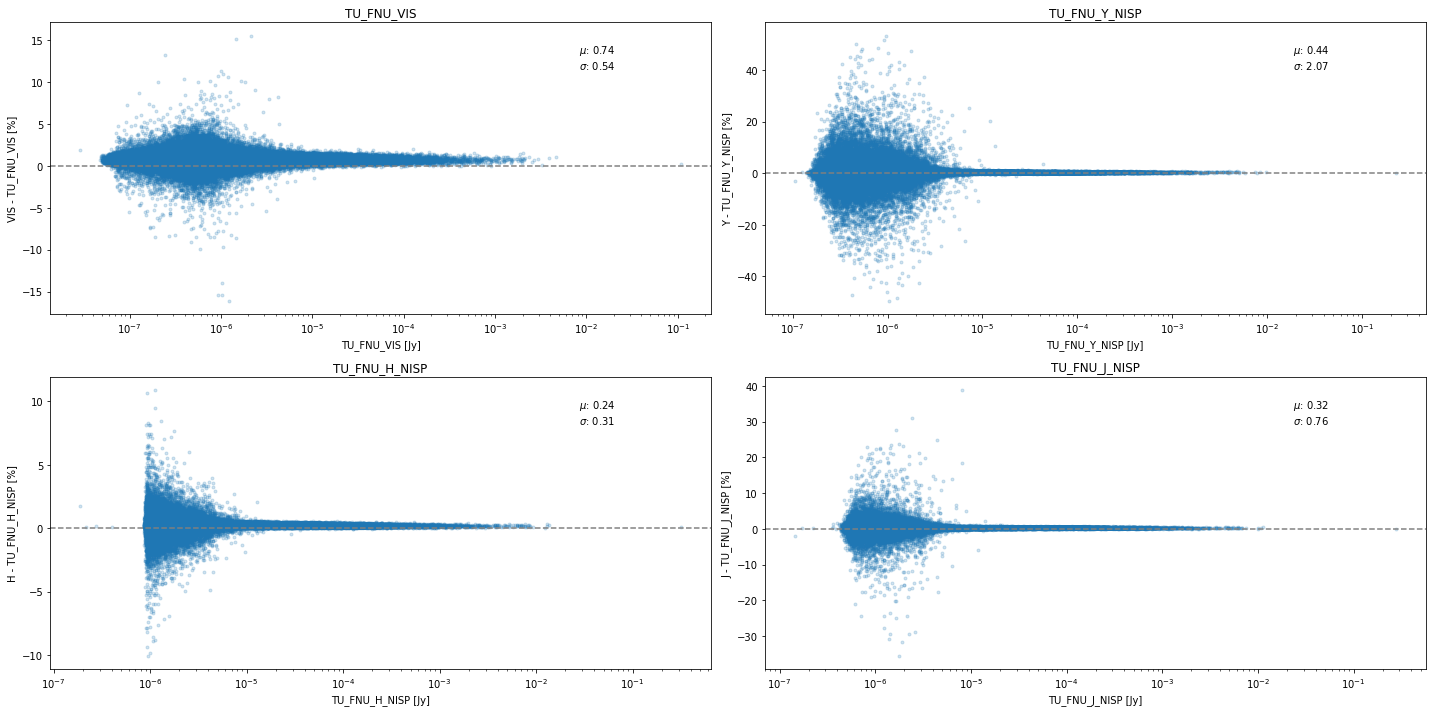

In [54]:
cols = 2
nrows = len(known_filters) // cols

fig, axes = plt.subplots(ncols=cols, nrows=nrows)

for (mer_filter, re_filter), ax in zip(known_filters, axes.ravel()):
    diff = 100 * (merged[re_filter] - merged[mer_filter]) / merged[mer_filter]
    ax.scatter(merged[mer_filter], diff, marker='.', alpha=.2)
    ax.axhline(0., c='gray', linestyle='--')
    ax.set_title(mer_filter)
    ax.set_xlabel(f'{mer_filter} [Jy]')
    ax.set_ylabel(f'{re_filter} - {mer_filter} [%]')
    ax.set_xscale('log')
    
    ax.text(0.8, 0.8, f"""
$\mu$: {np.mean(diff):.2f}
$\sigma$: {np.std(diff):.2f}
""", transform=ax.transAxes)

plt.tight_layout()

Seems the reconstructed fluxes are OK for the four Euclid bands. We can safely asume the fluxes for the IB filters should be OK too.

# Reference sample

We recompute the reference sample photometries including this time the Subaru IB filters, and the new Montercarlo method: 100 samples are drawn from the PDZ, used to re-redshift the object SED, and compute other photometries, obtaining an approximation of the photometry PDF.

In [28]:
ref_sample = ReferenceSample('/home/aalvarez/Work/Data/SC8/PHZ_Calibration/MergeReferenceSampleDirs/reference_sample_dir.dir/')

In [107]:
ref_photo = Table.read('/home/aalvarez/Work/Data/SC8/PHZ_Calibration/MergeReferenceSampleDirs/PhotometryWithIB.fits', hdu=1)
idx = np.arange(len(ref_photo))
np.random.shuffle(idx)
ref_photo_sample = ref_photo[idx[:10000]]

In [55]:
known_filters = [
    ('euclid/VIS', 'VIS_MC'),
    ('euclid/Y', 'Y_MC'),
]

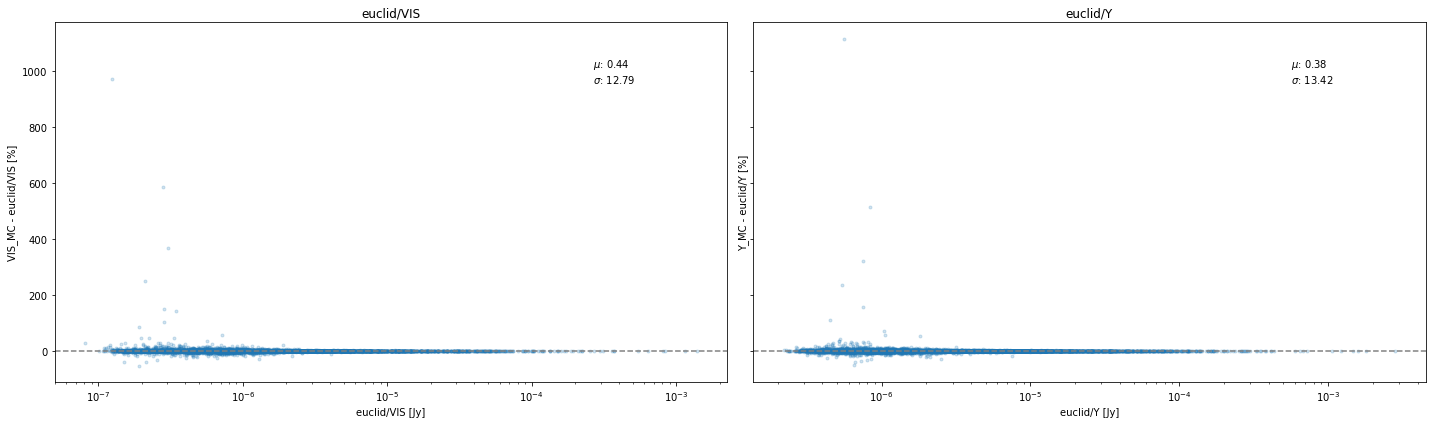

In [108]:
cols = 2
nrows = len(known_filters) // cols

fig, axes = plt.subplots(ncols=cols, nrows=nrows, sharey=True, figsize=(20, 6))

for (ref_filter, mc_mu), ax in zip(known_filters, axes.ravel()):
    diff = 100 * (ref_photo_sample[mc_mu] - ref_photo_sample[ref_filter]) / ref_photo_sample[ref_filter]
    ax.scatter(ref_photo_sample[ref_filter], diff, marker='.', alpha=.2)
    ax.axhline(0., c='gray', linestyle='--')
    ax.set_title(ref_filter)
    ax.set_xlabel(f'{ref_filter} [Jy]')
    ax.set_ylabel(f'{mc_mu} - {ref_filter} [%]')
    ax.set_xscale('log')
    
    ax.text(0.8, 0.8, f"""
$\mu$: {np.mean(diff):.2f}
$\sigma$: {np.std(diff):.2f}
""", transform=ax.transAxes)  

plt.tight_layout()

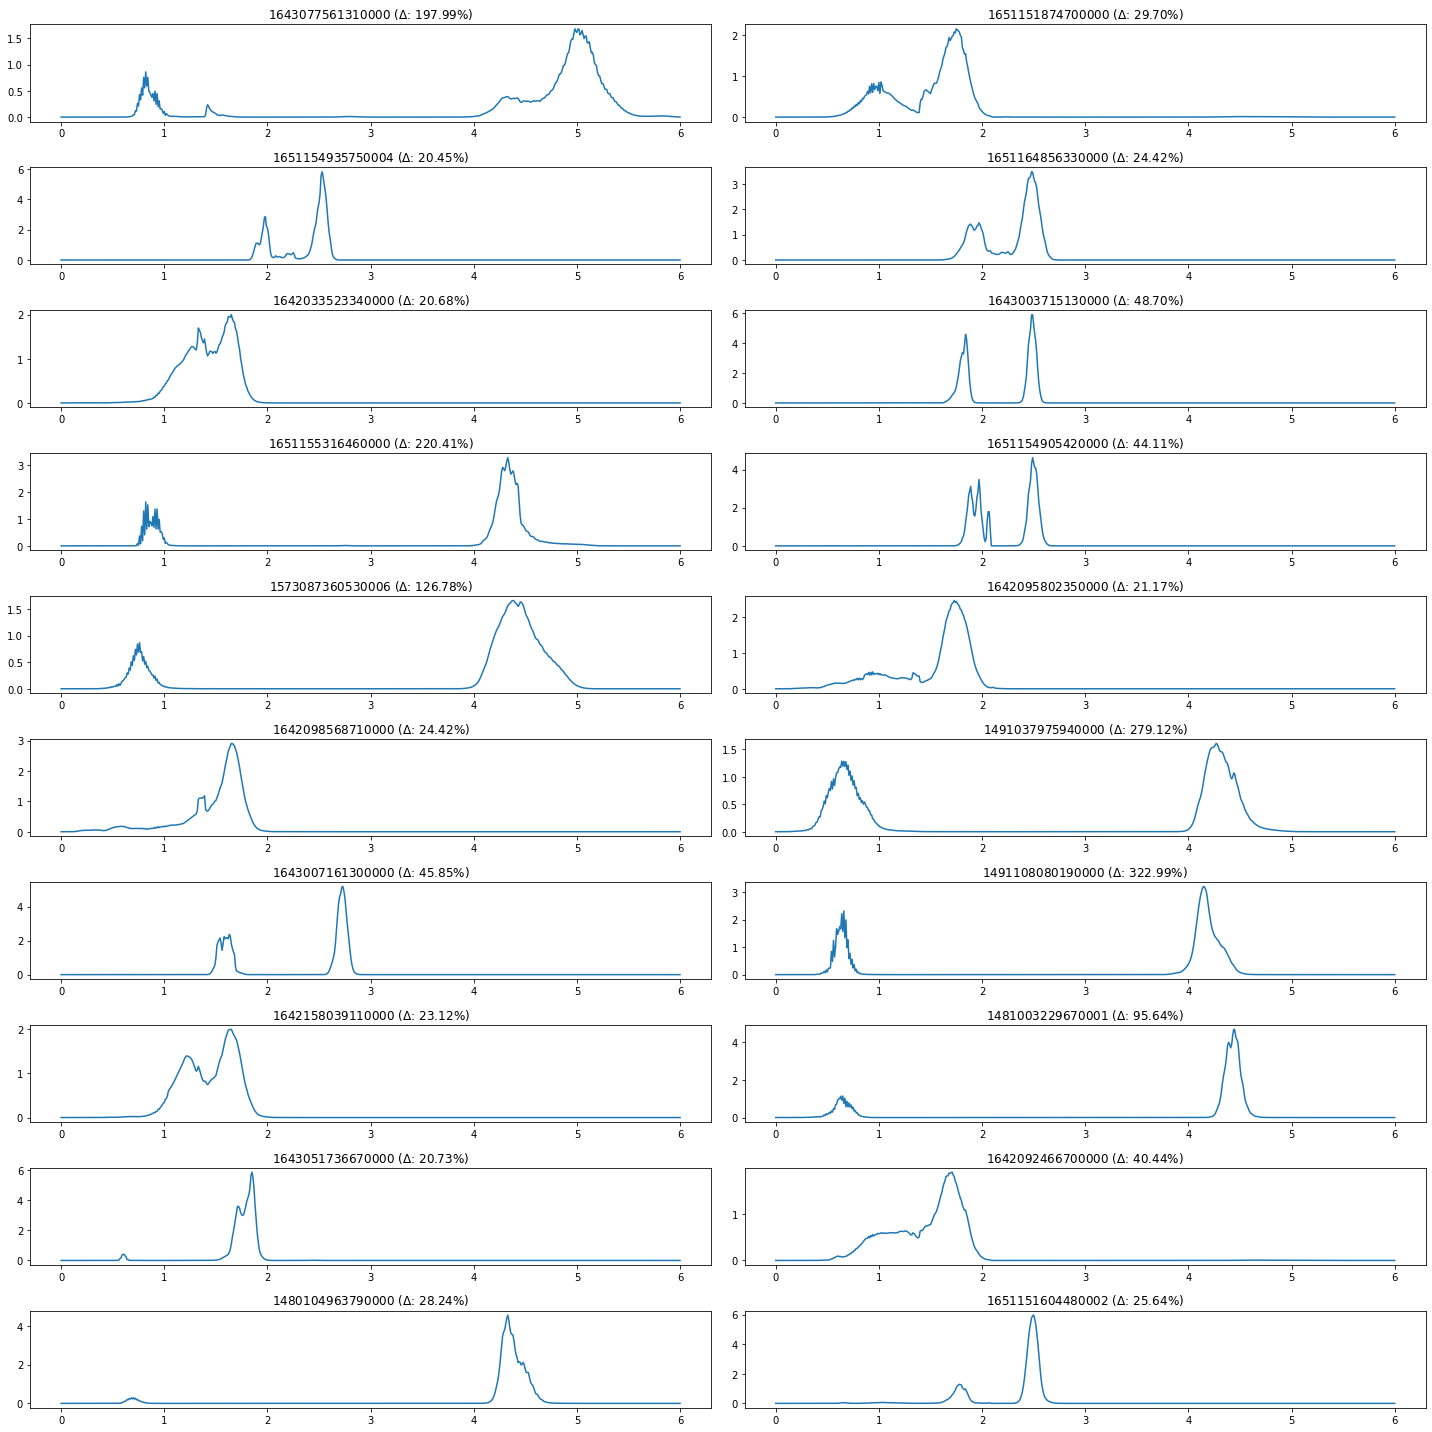

In [59]:
mask = diff > 20

fig, axes = plt.subplots(ncols=2, nrows=mask.sum()//2, figsize=(20, 20))

for obj_id, d, ax in zip(ref_photo['ID'][mask], diff[mask], axes.ravel()):
    ax.set_title(f'{obj_id} ($\Delta$: {d:.2f}%)')
    pdz = ref_sample.getPdzData(obj_id)
    ax.plot(pdz[:,0], pdz[:,1])
    
plt.tight_layout()

It also looks like the MC reconstruction is reasonable. There are some outliers, probably due to bi-modal PDZ.

# Recovered fluxes from NNPZ

We use the result catalog from the SC8 Cycle 3 NNPZ run. Note that, since we already have the neighbors, there is no need to 
re-run everything. We just use the tool `NnpzReconstructPDZ` (misnomer) to re-generate a new output.



In [45]:
reconstructed = Table.read('/home/aalvarez/Work/Data/SC8/PHZ_Prod/Nnpz/with_ib.fits', hdu=1)

In [46]:
reconstructed = join(reconstructed, merged, 'OBJECT_ID')

In [47]:
idx = np.arange(len(reconstructed))
np.random.shuffle(idx)
sample = reconstructed[idx[:10000]]

In [48]:
filters = [
    'VIS', 'IB427', 'IB464', 'IB484', 'IB505',
    'IB527', 'IB574', 'IB624', 'IB679', 'IB709',
    'IB738', 'IB767', 'IB827'
]

<ipython-input-64-d6ff743b907d>:10: RuntimeWarning: divide by zero encountered in true_divide
  diff = 100 * (sample[f_mc] - sample[f]) / sample[f]
<ipython-input-64-d6ff743b907d>:10: RuntimeWarning: invalid value encountered in true_divide
  diff = 100 * (sample[f_mc] - sample[f]) / sample[f]
<ipython-input-64-d6ff743b907d>:11: RuntimeWarning: divide by zero encountered in true_divide
  std = 100 * (sample[f_mc] + sample[f_mc_err] - sample[f]) / sample[f]
<ipython-input-64-d6ff743b907d>:11: RuntimeWarning: invalid value encountered in true_divide
  std = 100 * (sample[f_mc] + sample[f_mc_err] - sample[f]) / sample[f]
/home/aalvarez/miniconda3/envs/phz/lib/python3.8/site-packages/matplotlib/axes/_axes.py:3323: RuntimeWarning: invalid value encountered in float_scalars
  low = [v - e for v, e in zip(data, a)]


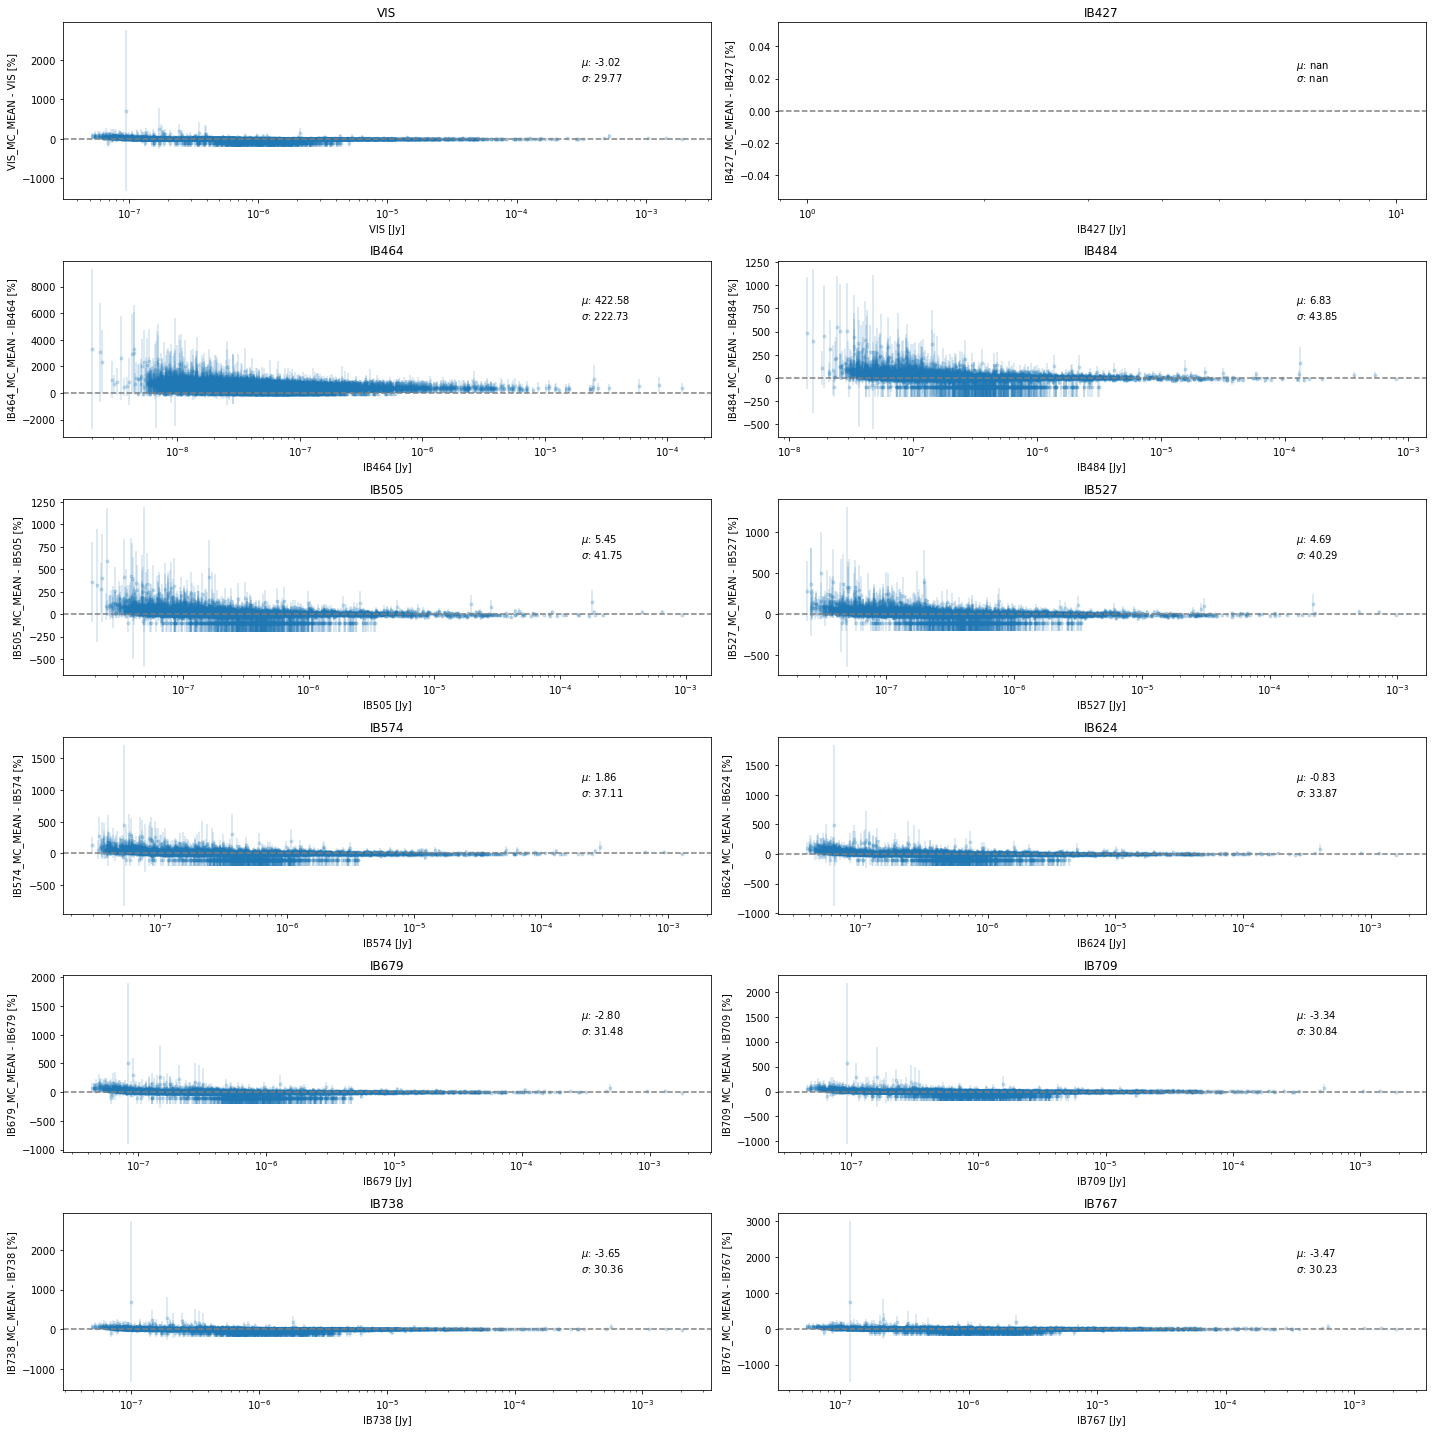

In [64]:
ncols = 2
nrows = len(filters) // 2

fig, axes = plt.subplots(ncols = ncols, nrows = nrows, figsize=(20, 20))

for f, ax in zip(filters, axes.ravel()):
    f_mc = f + '_MC_MEAN'
    f_mc_err = f + '_MC_MEAN_ERR'
    
    diff = 100 * (sample[f_mc] - sample[f]) / sample[f]
    std = 100 * (sample[f_mc] + sample[f_mc_err] - sample[f]) / sample[f]
    ax.scatter(sample[f], diff, marker='.', alpha=.2)
    ax.errorbar(sample[f], diff, std, fmt='none', alpha=.2)
    ax.axhline(0., c='gray', linestyle='--')
    ax.set_title(f)
    ax.set_xlabel(f'{f} [Jy]')
    ax.set_ylabel(f'{f_mc} - {f} [%]')
    ax.set_xscale('log')
    
    ax.text(0.8, 0.6, f"""
$\mu$: {np.mean(diff):.2f}
$\sigma$: {np.std(diff):.2f}
""", transform=ax.transAxes)  
    

    
plt.tight_layout()

# Reconstructed with S/N and MAG_VIS cuts

In [75]:
snr = reconstructed['FLUX_VIS_APER'] / reconstructed['FLUXERR_VIS_APER'] >= 10
mag_cut = (reconstructed['FLUX_VIS_APER'] * u.Jy).to(u.ABmag) <= 24.5 * u.ABmag

In [76]:
mask = np.logical_and(snr, mag_cut)
print(mask.sum() / len(reconstructed))

0.503864734299517


In [79]:
cut = reconstructed[mask]
idx = np.arange(len(cut))
np.random.shuffle(idx)
sample = cut[idx[:10000]]

<ipython-input-84-d6ff743b907d>:10: RuntimeWarning: divide by zero encountered in true_divide
  diff = 100 * (sample[f_mc] - sample[f]) / sample[f]
<ipython-input-84-d6ff743b907d>:10: RuntimeWarning: invalid value encountered in true_divide
  diff = 100 * (sample[f_mc] - sample[f]) / sample[f]
<ipython-input-84-d6ff743b907d>:11: RuntimeWarning: divide by zero encountered in true_divide
  std = 100 * (sample[f_mc] + sample[f_mc_err] - sample[f]) / sample[f]
<ipython-input-84-d6ff743b907d>:11: RuntimeWarning: invalid value encountered in true_divide
  std = 100 * (sample[f_mc] + sample[f_mc_err] - sample[f]) / sample[f]


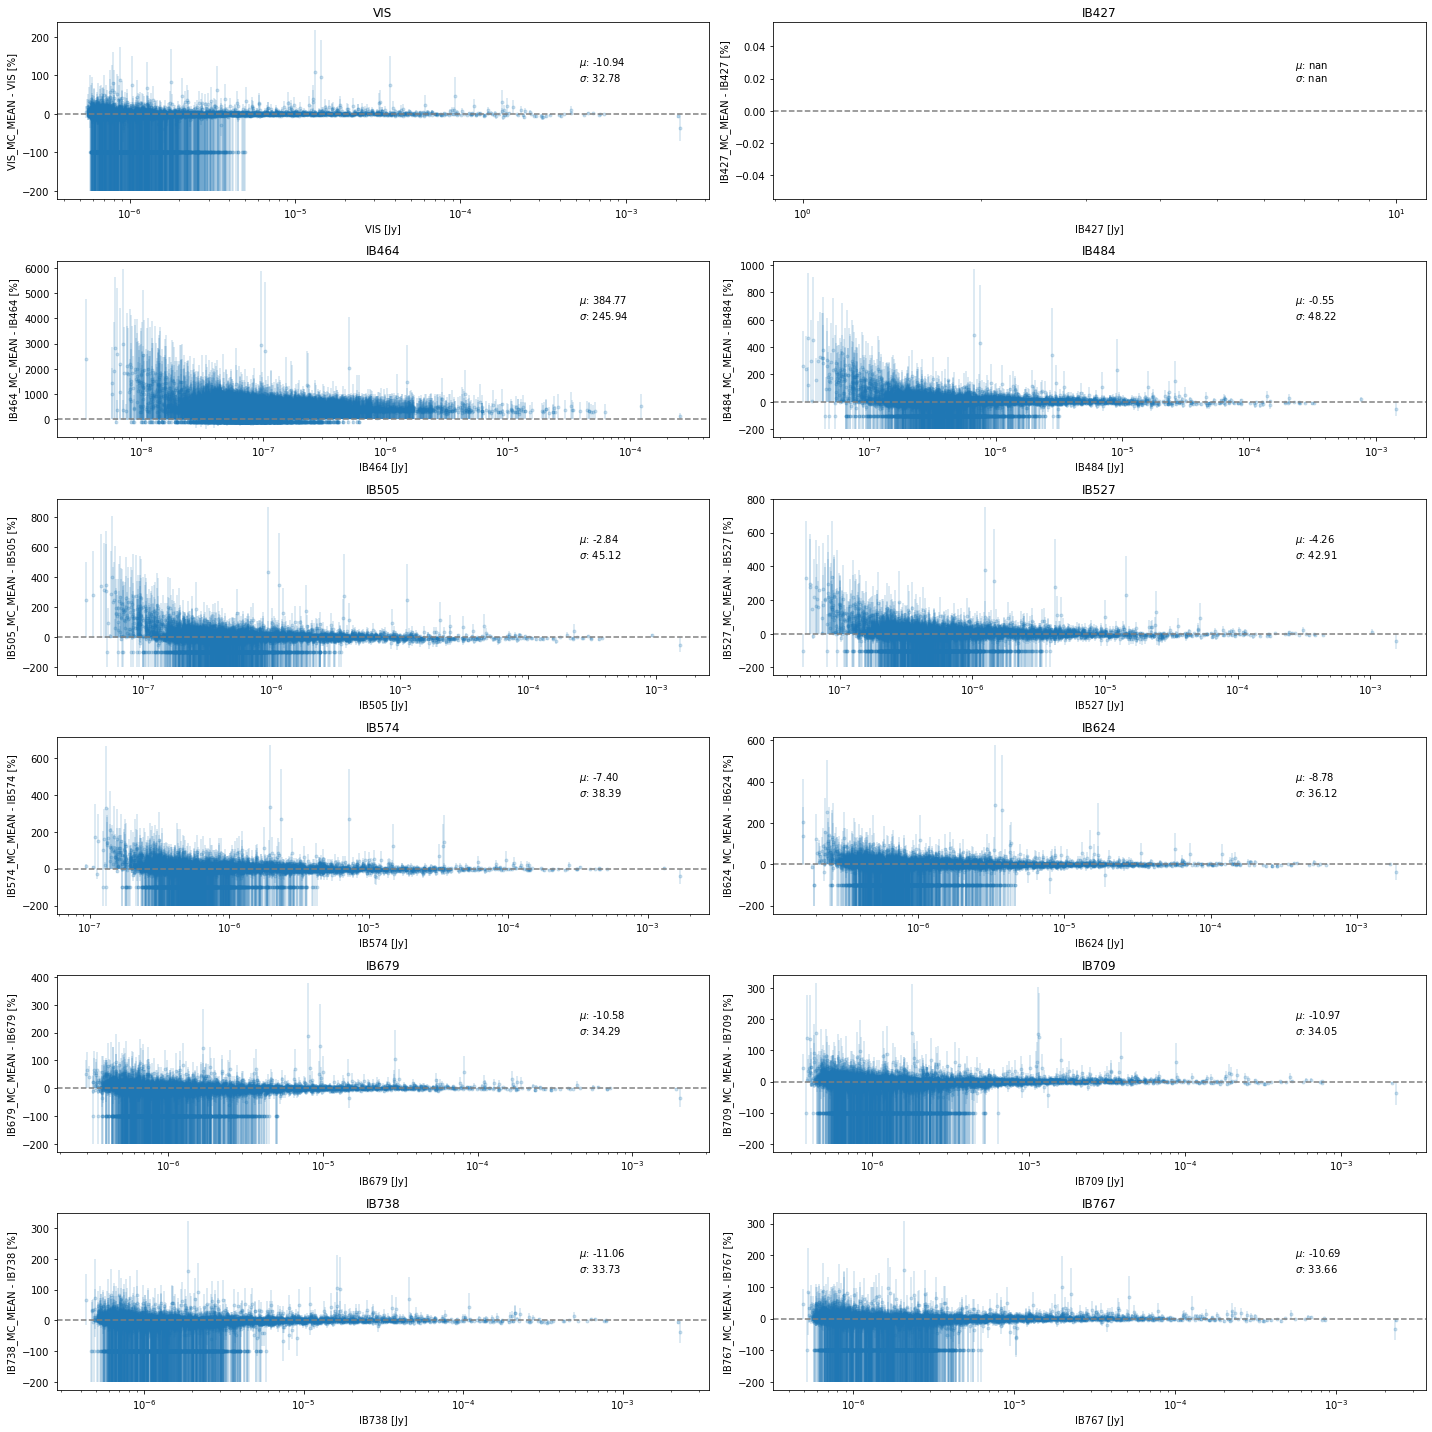

In [84]:
ncols = 2
nrows = len(filters) // 2

fig, axes = plt.subplots(ncols = ncols, nrows = nrows, figsize=(20, 20))

for f, ax in zip(filters, axes.ravel()):
    f_mc = f + '_MC_MEAN'
    f_mc_err = f + '_MC_MEAN_ERR'
    
    diff = 100 * (sample[f_mc] - sample[f]) / sample[f]
    std = 100 * (sample[f_mc] + sample[f_mc_err] - sample[f]) / sample[f]
    ax.scatter(sample[f], diff, marker='.', alpha=.2)
    ax.errorbar(sample[f], diff, std, fmt='none', alpha=.2)
    ax.axhline(0., c='gray', linestyle='--')
    ax.set_title(f)
    ax.set_xlabel(f'{f} [Jy]')
    ax.set_ylabel(f'{f_mc} - {f} [%]')
    ax.set_xscale('log')
    
    ax.text(0.8, 0.6, f"""
$\mu$: {np.mean(diff):.2f}
$\sigma$: {np.std(diff):.2f}
""", transform=ax.transAxes)  
    

    
plt.tight_layout()